Purpose: Run random forest binary classification on drought data. Split the testing data off using Jeremy's "leave out one BioProject" strategy to avoid data leakage. Also, to avoid data leakage, do as much preprocessing of data as possible after train_test_split. Try scaling as well as log transformation.<br>
Author: Anna Pardo<br>
Date initiated: June 15, 2023

In [1]:
# load modules
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

### Section 1: Data loading, train test split, and preprocessing

In [2]:
# load the raw TPM
# TPM of all non-3' RNA-seq data from SRA
tpm_non3prime = pd.read_csv("../../data/TPM_LS_allsamp_05-May-2023.txt",sep="\t",header="infer")
tpm_non3prime.head()

,SRR8857799,SRR8857793,SRR15241108,SRR15241156,SRR8857749,SRR8857746,SRR15241170,SRR8857844,SRR9282931,SRR2106196,...,SRR11933188,SRR11933232,SRR11933226,SRR11933391,SRR11933084,SRR11932980,SRR4431530,SRR11933278,SRR11933248,GeneID
0,8.477884,1.349336,15.116249,13.781893,4.872421,32.421567,13.266106,10.918767,1.099232,5.291619,...,15.304726,9.054337,8.371502,6.884535,23.167063,10.531549,1.939595,3.661932,12.195099,Zm00001eb000010
1,102.011193,39.493900,0.808690,0.565147,13.808307,1.344191,1.035099,124.754873,45.137300,18.872878,...,3.608441,0.926072,3.874467,3.166363,3.762337,0.231235,0.000000,0.767166,2.757692,Zm00001eb000020
2,0.492838,0.000000,0.000000,0.000000,0.519128,2.733165,0.000000,1.152023,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.999909,0.000000,0.000000,0.076395,0.000000,Zm00001eb000050
3,28.480082,7.311609,35.563727,18.684174,7.134804,28.603220,22.302009,34.742011,2.411356,4.794730,...,12.338421,6.851312,10.411906,3.112488,19.269589,0.000000,1.254026,5.877407,14.959614,Zm00001eb000060
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.360438,...,12.758565,1.048543,10.708364,2.937489,3.235341,2.842873,0.000000,12.544630,2.985126,Zm00001eb000070


In [3]:
# drop columns with duplicated samples from tpm_non3prime
tpm_non3prime.drop(["SRR21494916.1","SRR21494925.1"],axis=1,inplace=True)

In [4]:
# load TPM matrix of Brandon Webster's BRB-seq data
tpm_brb = pd.read_csv("../../data/Webster_TPM.txt",sep="\t",header="infer")
tpm_brb.head()

,B73xMO17_HII_1_BRB1,B73xMO17_HII_2_BRB3,B73xMO17_HI_2_BRB4,B73xMO17_HII_3_BRB4,B73xMO17_HI_3_BRB6,B73xMO17_HIV_1_BRB1,B73xMO17_HIII_1_BRB1,B73xMO17_HIV_2_BRB3,B73xMO17_HIII_2_BRB3,B73xMO17_HIV_3_BRB5,...,PHB47xPHN82_LI_2_BRB3,PHB47xPHN82_LII_3_BRB4,PHB47xPHN82_LI_3_BRB6,PHB47xPHN82_LIII_1_BRB1,PHB47xPHN82_LIV_1_BRB2,PHB47xPHN82_LIII_2_BRB3,PHB47xPHN82_LIV_2_BRB4,PHB47xPHN82_LIV_3_BRB5,PHB47xPHN82_LIII_3_BRB5,GeneID
0,2.114086,1.660552,1.878490,2.620810,1.317652,3.080075,3.647894,1.290750,2.488043,1.577500,...,2.405001,2.075818,2.550406,3.430640,3.498847,2.108796,4.628517,1.828765,2.625361,Zm00001eb000010
1,3.659127,1.021915,0.500743,2.441291,1.390101,0.539431,1.479619,1.421682,1.813215,0.369439,...,1.470443,0.923670,1.421757,0.754487,1.271345,2.052833,2.214001,2.473819,0.950585,Zm00001eb000020
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251069,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Zm00001eb000050
3,11.195980,1.765126,2.114247,1.432727,0.000000,0.488056,0.000000,0.220506,2.863466,0.000000,...,0.000000,0.000000,0.000000,3.449083,0.000000,1.152822,0.948857,0.000000,0.000000,Zm00001eb000060
4,0.000000,0.000000,0.035727,0.042368,0.000000,0.000000,0.000000,0.052166,0.000000,0.023723,...,0.000000,0.031217,0.029450,0.356984,0.000000,0.000000,0.000000,0.000000,0.019075,Zm00001eb000070


In [5]:
# load TPM matrix of Jeremy Pardo's 3' RNA-seq data
tpm_3prime = pd.read_csv("../../data/TPM_counts.txt",sep="\t",header="infer")
tpm_3prime.head()

,CML69D1D,HP301D1C,Ky21D1C,IL14HD3C,MO18WD3D,B73D1C,IL14HD1C,Tx303D1D,CmL277D1C,Ky21D1D,...,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D,GeneID
0,2.253948,1.322243,1.611850,4.395168,2.614455,1.583103,4.356111,3.154567,2.864024,0.407748,...,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243,Zm00001eb000010
1,1.909826,0.390948,0.510434,1.661760,3.191106,0.334074,1.103666,0.152782,1.674700,0.000000,...,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832,Zm00001eb000020
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Zm00001eb000050
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Zm00001eb000060
4,0.171388,0.000000,0.000000,0.000000,1.404912,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587,Zm00001eb000070


In [6]:
# merge on gene ID
tpm_all = tpm_brb.merge(tpm_3prime.merge(tpm_non3prime, how="inner",on="GeneID"),how="inner",on="GeneID")
tpm_all.set_index("GeneID",inplace=True)
tpm_all.head()

,B73xMO17_HII_1_BRB1,B73xMO17_HII_2_BRB3,B73xMO17_HI_2_BRB4,B73xMO17_HII_3_BRB4,B73xMO17_HI_3_BRB6,B73xMO17_HIV_1_BRB1,B73xMO17_HIII_1_BRB1,B73xMO17_HIV_2_BRB3,B73xMO17_HIII_2_BRB3,B73xMO17_HIV_3_BRB5,...,SRR11933010,SRR11933188,SRR11933232,SRR11933226,SRR11933391,SRR11933084,SRR11932980,SRR4431530,SRR11933278,SRR11933248
GeneID,,,,,,,,,,,,,,,,,,,,,
Zm00001eb000010,2.114086,1.660552,1.878490,2.620810,1.317652,3.080075,3.647894,1.290750,2.488043,1.577500,...,5.045644,15.304726,9.054337,8.371502,6.884535,23.167063,10.531549,1.939595,3.661932,12.195099
Zm00001eb000020,3.659127,1.021915,0.500743,2.441291,1.390101,0.539431,1.479619,1.421682,1.813215,0.369439,...,1.329592,3.608441,0.926072,3.874467,3.166363,3.762337,0.231235,0.000000,0.767166,2.757692
Zm00001eb000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251069,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.999909,0.000000,0.000000,0.076395,0.000000
Zm00001eb000060,11.195980,1.765126,2.114247,1.432727,0.000000,0.488056,0.000000,0.220506,2.863466,0.000000,...,2.380904,12.338421,6.851312,10.411906,3.112488,19.269589,0.000000,1.254026,5.877407,14.959614
Zm00001eb000070,0.000000,0.000000,0.035727,0.042368,0.000000,0.000000,0.000000,0.052166,0.000000,0.023723,...,11.307018,12.758565,1.048543,10.708364,2.937489,3.235341,2.842873,0.000000,12.544630,2.985126


In [7]:
# transpose TPM data
ttpm = tpm_all.transpose()
ttpm.head()

GeneID,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
B73xMO17_HII_1_BRB1,2.114086,3.659127,0.0,11.195980,0.000000,8.487909,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B73xMO17_HII_2_BRB3,1.660552,1.021915,0.0,1.765126,0.000000,5.350063,0.0,0.0,0.411018,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B73xMO17_HI_2_BRB4,1.878490,0.500743,0.0,2.114247,0.035727,5.126593,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B73xMO17_HII_3_BRB4,2.620810,2.441291,0.0,1.432727,0.042368,5.845763,0.0,0.0,1.167661,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B73xMO17_HI_3_BRB6,1.317652,1.390101,0.0,0.000000,0.000000,3.246945,0.0,0.0,0.559104,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# load metadata (only columns Sample, BioProject, and Treatment are required)
md = pd.read_csv("../../data/srr_numbers_with_metadata_12-May-2023.csv",sep=",",header="infer",usecols=["BioProject","Sample","Treatment"])
md.head()

,BioProject,Sample,Treatment
0,PRJNA637522,SRR11933261,Drought
1,PRJNA637522,SRR11933272,Drought
2,PRJNA637522,SRR11933250,Drought
3,PRJNA637522,SRR11933029,Control
4,PRJNA637522,SRR11933040,Drought


In [47]:
md.drop(["Sample","Treatment"],axis=1)

,BioProject
0,PRJNA637522
1,PRJNA637522
2,PRJNA637522
3,PRJNA637522
4,PRJNA637522
...,...
2062,PRJNA906711
2063,PRJNA906711
2064,PRJNA906711
2065,PRJNA906711


In [11]:
md["Treatment"].unique()

array(['Drought', 'Control', 'Heat', 'Cold', 'Salt', 'UV', 'ControlRec',
       'DroughtRec', 'DroughtSalt', 'SaltRec', 'DroughtSaltRec',
       'ColdRec', 'ColdDroughtRec', 'ColdDrought', 'DroughtRepeat',
       'Low_Nitrogen', 'Flooding', 'PEG6000'], dtype=object)

In [8]:
# side quest: wrange ttpm into shape for saving as a file
ttpm_forfile = ttpm.reset_index().rename(columns={"index":"Sample"})

In [12]:
# merge with metadata, then remove certain samples (UV, recovery, combined stresses)
ttpm_forfile = md.merge(ttpm_forfile)

In [13]:
ttpm_forfile.head()

,BioProject,Sample,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,PRJNA637522,SRR11933261,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,PRJNA637522,SRR11933272,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,PRJNA637522,SRR11933250,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,PRJNA637522,SRR11933029,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,PRJNA637522,SRR11933040,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [14]:
ttpm_forfile = ttpm_forfile[~ttpm_forfile["Treatment"].isin(["UV","ControlRec","DroughtRec","DroughtSalt","SaltRec",
                                                           "DroughtSaltRec","ColdRec","ColdDroughtRec","ColdDrought"])]
ttpm_forfile["Treatment"].unique()

array(['Drought', 'Control', 'Heat', 'Cold', 'Salt', 'DroughtRepeat',
       'Low_Nitrogen', 'Flooding', 'PEG6000'], dtype=object)

In [87]:
stressors = ["Drought","Heat","Salt","Cold","Flooding","Low_Nitrogen"]

In [88]:
# write text file of stressors
with open("../../data/stressors.txt","w+") as outfile:
    for i in stressors:
        outfile.write(i+"\n")

In [16]:
# save ttpm to a file for ease of future access
ttpm_forfile = ttpm_forfile.drop(["BioProject","Treatment"],axis=1)
ttpm_forfile.to_csv("../../data/all_raw_tpm_15-Jun-2023.tsv",sep="\t",header=True,index=False)

In [3]:
# load ttpm
ttpm = pd.read_csv("../../data/all_raw_tpm_15-Jun-2023.tsv",sep="\t",header="infer",index_col="Sample")
ttpm.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.0,1.122904,0.0,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
SRR11933272,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.0,2.280915,0.0,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
SRR11933250,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.0,1.908468,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
SRR11933029,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,0.0,1.619452,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
SRR11933040,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.0,2.264390,0.0,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [31]:
# section started June 21, 2023: split off one stressor (example: cold) from the dataset
## start by merging ttpm with metadata to add a BioProject column
mttpm = md[["Sample","BioProject","Treatment"]].merge(ttpm.reset_index().rename(columns={"index":"Sample"}))
mttpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [32]:
len(mttpm.index)

2017

In [34]:
# save mttpm to a file both with and without PEG
mttpm.to_csv("../../data/rawtpm_bptreat_all.tsv",sep="\t",header=True,index=False)

In [37]:
# remove PEG BioProject
np = mttpm[mttpm["BioProject"]!="PRJNA432945"]

In [38]:
# save np to a file
np.to_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header=True,index=False)

In [41]:
np[np["Treatment"]=="Heat"]["BioProject"].unique()

array(['PRJNA506720', 'PRJNA244661', 'PRJNA747925', 'PRJNA520822',
       'PRJNA548548', 'PRJNA791560', 'PRJNA349117', 'PRJNA646054'],
      dtype=object)

In [43]:
cbp = np[np["Treatment"]=="Cold"]["BioProject"].unique()

In [45]:
# starting from np: split off all cold data, with associated controls, from the full dataset
cold = np[np["BioProject"].isin(cbp)]
cold = cold[cold["Treatment"].isin(["Cold","Control"])]
len(cold.index)

474

In [4]:
# drop all non-drought BioProjects
## start by dropping all samples not labeled drought or control
mddc = md[md["Treatment"].isin(["Drought","DroughtRepeat","Control"])]

In [5]:
# now remove all BioProjects that only have control samples
for b in mddc["BioProject"].unique():
    df = mddc[mddc["BioProject"]==b]
    if len(df["Treatment"].unique()) == 1:
        mddc = mddc[mddc["BioProject"] != b]

In [6]:
# labeling: set Control to 0 and any stress to 1
proxy = []
for i in range(len(mddc.index)):
    if mddc.iloc[i,2] == "Control":
        proxy.append(0)
    else:
        proxy.append(1)
mddc["Label"] = proxy

In [7]:
# merge labels with TPM
tpmlab = mddc[["Sample","BioProject","Label"]].merge(ttpm.reset_index().rename(columns={"index":"Sample"}))
tpmlab.head()

,Sample,BioProject,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,1,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,1,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,1,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,0,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,1,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [2]:
# make a function for loading & cleaning data, including labeling
def load_clean_data(path_to_tpm,single_stress="none"):
    """
    Args:
        path_to_tpm = full path to file containing raw TPM, columns for Sample, BioProject, & Treatment
        single_stress = a single stressor to which the data must be subsetted, or "none" (default)
    """
    # load the TPM data
    raw_tpm = pd.read_csv(path_to_tpm,sep="\t",header="infer")
    # if there is a single stress to subset to, subset to that stress
    if single_stress != "none":
        if single_stress == "Drought":
            raw_tpm = raw_tpm[raw_tpm["Treatment"].isin(["Drought","DroughtRepeat","Control"])]
        else:
            raw_tpm = raw_tpm[raw_tpm["Treatment"].isin([single_stress,"Control"])]
        # remove BioProjects that only have control samples left
        testdf = raw_tpm[["Sample","BioProject","Treatment"]]
        for b in testdf["BioProject"].unique():
            df = testdf[testdf["BioProject"]==b]
            if len(df["Treatment"].unique())==1:
                testdf = testdf[testdf["BioProject"]!=b]
        raw_tpm = raw_tpm.merge(testdf)
    # labeling: set Control to 0 and any stress to 1
    proxy = []
    for i in range(len(raw_tpm.index)):
        if raw_tpm.iloc[i,raw_tpm.columns.get_loc("Treatment")] == "Control":
            proxy.append(0)
        else:
            proxy.append(1)
    raw_tpm["Label"] = proxy
    # return the dataframe
    return raw_tpm

In [3]:
# test function
flood = load_clean_data("../../data/rawtpm_bptreat_all.tsv",single_stress="Flooding")

In [55]:
flood["Label"].value_counts()[0]

21

In [4]:
# define a function to check if the data are balanced
def check_if_balanced(labeled_tpm):
    """
    Args:
        labeled_tpm = raw TPM with columns for Sample, BioProject, Label, Treatment
    """
    if labeled_tpm["Label"].value_counts()[0] == labeled_tpm["Label"].value_counts()[1]:
        return True
    else:
        return False

In [59]:
sampling = "Down"
if sampling == "Down":
    ds = True
else:
    ds = False

In [60]:
ds

True

In [5]:
check_if_balanced(flood)

False

In [6]:
def downsample(dataframe):
    """
    Args:
        dataframe = a log TPM dataframe with a Label column and Sample set as the index
    """
    # generate a variable of value counts
    vc = dataframe["Label"].value_counts()

    # subset data to only samples labeled 1
    ones_only = dataframe[dataframe["Label"]==1]
    
    # downsample from the subsetted dataframe
    ds = ones_only.sample(n=vc[1],random_state=42)

    # subset original data to control samples
    zeroes = dataframe[dataframe["Label"]==0]

    # concatenate controls and downsampled stress samples
    downsampled = pd.concat([ds,zeroes])
    # return dataframe
    return downsampled

In [7]:
# define a function for variance thresholding, log transformation, downsampling if required
def pre_split_transform(raw_tpm,balanced,downsample=False):
    """
    Args:
        raw_tpm = dataframe containing raw TPM values, columns for Sample, BioProject, Treatment, Label
        balanced = Boolean variable, True or False (result of check_if_balanced())
        downsample = Boolean variable, True or False, default False (set manually outside function)
    """
    # temporarily, set index to Sample and drop BioProject, Label, & Treatment columns
    blt = raw_tpm[["Sample","BioProject","Treatment","Label"]]
    tpmi = raw_tpm.set_index("Sample").drop(["BioProject","Treatment","Label"],axis=1)
    # remove zero-variance genes
    vttpm = variance_threshold_selector(tpmi)
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # downsample data if needed
    if balanced==True:
        if downsample==True:
            # add back labels
            vttpm_log = blt[["Sample","Label"]].merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
            # set Sample as index
            vttpm_log = vttpm_log.set_index("Sample")
            # downsample the data
            vttpm_log = downsample(vttpm_log)
    # add treatment, labels, and BioProject back in, set Sample as the index again
    labeled = blt.merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
    labeled.set_index("Sample",inplace=True)
    # return dataframe
    return labeled

In [8]:
# define a function from an answer in https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

Because `VarianceThreshold()` is set to the default (remove all features with 0 variance across samples), I must apply it before splitting the training and testing data. Otherwise there might be different features between train and test sets.

In [9]:
flood_log = pre_split_transform(flood,False,False)

In [11]:
flood_log.head()

,BioProject,Treatment,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR1656746,PRJNA267717,Control,0,2.571453,3.100322,0.000000,2.324170,0.489994,1.152727,0.0,...,0.0,0.325871,0.425762,0.0,0.0,0.0,0.0,0.0,0.0,0.647908
SRR1656747,PRJNA267717,Control,0,1.546580,3.157299,0.095248,1.068310,0.000000,0.456112,0.0,...,0.0,0.330592,0.144683,0.0,0.0,0.0,0.0,0.0,0.0,1.154782
SRR1656748,PRJNA267717,Control,0,1.728674,3.026357,0.111172,1.075662,0.000000,0.669258,0.0,...,0.0,0.000000,0.028466,0.0,0.0,0.0,0.0,0.0,0.0,0.923362
SRR1656758,PRJNA267717,Flooding,1,0.591905,2.616303,0.000000,0.680880,0.000000,0.117627,0.0,...,0.0,0.000000,0.215789,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
SRR1656759,PRJNA267717,Flooding,1,1.287845,2.913773,0.158284,1.515598,0.088839,0.580917,0.0,...,0.0,0.347162,0.248853,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
flood.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,SRR1656746,PRJNA267717,Control,4.944077,7.576104,0.000000,4.007775,0.404439,1.223337,0.0,...,0.343282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566894,0
1,SRR1656747,PRJNA267717,Control,1.921238,7.921579,0.068249,1.096976,0.000000,0.371840,0.0,...,0.105488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.226507,0
2,SRR1656748,PRJNA267717,Control,2.314230,7.147498,0.080105,1.107689,0.000000,0.590255,0.0,...,0.019927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.896530,0
3,SRR1656758,PRJNA267717,Flooding,0.507236,5.131766,0.000000,0.603117,0.000000,0.084949,0.0,...,0.161339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
4,SRR1656759,PRJNA267717,Flooding,1.441630,6.535862,0.115959,1.859174,0.063514,0.495800,0.0,...,0.188262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1


In [13]:
len(flood_log.index)

69

In [9]:
# for tpmlab, set Sample column as index and temporarily drop BioProject & Label columns
tpmi = tpmlab.set_index("Sample").drop(["BioProject","Label"],axis=1)
tpmi.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.0,1.122904,0.0,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
SRR11933272,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.0,2.280915,0.0,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
SRR11933250,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.0,1.908468,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
SRR11933029,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,0.0,1.619452,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
SRR11933040,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.0,2.264390,0.0,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [10]:
# put through VarianceThreshold() using the variance_threshold_selector() defined above
vttpm = variance_threshold_selector(tpmi)
vttpm.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,0.0,1.122904,0.0,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
SRR11933272,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,0.0,2.280915,0.0,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
SRR11933250,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,0.0,1.908468,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
SRR11933029,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,0.0,1.619452,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
SRR11933040,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,0.0,2.264390,0.0,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [24]:
# find how many low-variance genes were eliminated
len(tpmi.columns)-len(vttpm.columns)

63

The above indicates that there were 63 genes with zero variance across all drought & associated control samples.

In [11]:
# log-transform TPM
vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
vttpm_log.head()

,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,Zm00001eb000140,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,1.086039,0.0,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
SRR11933272,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,1.714098,0.0,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
SRR11933250,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,1.540259,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
SRR11933029,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,1.389265,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
SRR11933040,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,1.706813,0.0,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [12]:
# add labels and BioProject back in
labeled = mddc[["Sample","BioProject","Label"]].merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
labeled.set_index("Sample",inplace=True)
labeled.head()

,BioProject,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,PRJNA637522,1,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
SRR11933272,PRJNA637522,1,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
SRR11933250,PRJNA637522,1,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
SRR11933029,PRJNA637522,0,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
SRR11933040,PRJNA637522,1,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [13]:
# drop any rows with NAs
## in this case there are none to drop
labeled.dropna(inplace=True)

In [14]:
len(labeled.index)

985

In [37]:
# check if the data are balanced
labeled["Label"].value_counts()

1    608
0    377
Name: Label, dtype: int64

### Section 2: Random forest modeling

In [15]:
flood_log["BioProject"].unique()

array(['PRJNA267717', 'PRJNA606824', 'PRJNA687609'], dtype=object)

In [29]:
labeled.head()

,BioProject,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,PRJNA637522,1,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
SRR11933272,PRJNA637522,1,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
SRR11933250,PRJNA637522,1,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
SRR11933029,PRJNA637522,0,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
SRR11933040,PRJNA637522,1,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [19]:
flood_log.head()

,BioProject,Treatment,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR1656746,PRJNA267717,Control,0,2.571453,3.100322,0.000000,2.324170,0.489994,1.152727,0.0,...,0.0,0.325871,0.425762,0.0,0.0,0.0,0.0,0.0,0.0,0.647908
SRR1656747,PRJNA267717,Control,0,1.546580,3.157299,0.095248,1.068310,0.000000,0.456112,0.0,...,0.0,0.330592,0.144683,0.0,0.0,0.0,0.0,0.0,0.0,1.154782
SRR1656748,PRJNA267717,Control,0,1.728674,3.026357,0.111172,1.075662,0.000000,0.669258,0.0,...,0.0,0.000000,0.028466,0.0,0.0,0.0,0.0,0.0,0.0,0.923362
SRR1656758,PRJNA267717,Flooding,1,0.591905,2.616303,0.000000,0.680880,0.000000,0.117627,0.0,...,0.0,0.000000,0.215789,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
SRR1656759,PRJNA267717,Flooding,1,1.287845,2.913773,0.158284,1.515598,0.088839,0.580917,0.0,...,0.0,0.347162,0.248853,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [10]:
# set up the train test split
# strategy: hold out one BioProject at a time for testing
# write a function that takes BioProject as an argument and then splits and preps the data
def split_prep_data(bioproject,dataframe,balance="up"):
    """
    Args:
        bioproject = BioProject to hold out for testing (PRJNAXXXXXX)
        dataframe = starting dataframe of log TPM with labels
        balance = str: "none","up" (downsampling will be done before splitting, outside of this function)
    """
    # if data have treatment column, drop it
    if "Treatment" in dataframe.columns:
        dataframe = dataframe.drop("Treatment",axis=1)
    # split training and testing sets
    test = dataframe[dataframe["BioProject"]==bioproject]
    train = dataframe[dataframe["BioProject"]!=bioproject]
    # drop BioProject column from both sets
    test = test.drop("BioProject",axis=1)
    train = train.drop("BioProject",axis=1)
    # generate X_train, X_test, y_train, and y_test
    ## where X = gene expression values and y = class labels
    train_X = train.drop("Label",axis=1)
    y_train = train["Label"]
    test_X = test.drop("Label",axis=1)
    y_test = test["Label"]
    # if upsampling: do the upsampling using SMOTE
    if balance=="up":
        sm = SMOTE(random_state=42)
        train_X, y_train = sm.fit_resample(train_X,y_train)
    # for X_train and X_test: scale data to a z-score
    scalar = StandardScaler()
    X_train = scalar.fit_transform(train_X)
    X_test = scalar.fit_transform(test_X)
    # return training and test data
    return X_train, y_train, X_test, y_test

In [11]:
# now write a function for modeling
# credit for this function: Dr. Jeremy Pardo
def get_tuned_rf(X_train, y_train, random_grid):
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf,
                                  param_distributions=random_grid,
                                  n_iter=10,
                                  cv=5,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1)
    rf_random.fit(X_train, y_train)
    hyper = rf_random.best_params_
    rfclf_tune = RandomForestClassifier(n_estimators=hyper["n_estimators"],
                                min_samples_split=hyper["min_samples_split"],
                                    min_samples_leaf=hyper["min_samples_leaf"],
                                   max_features=hyper["max_features"],
                                   max_depth=hyper["max_depth"],
                                   bootstrap=hyper["bootstrap"])
    return rfclf_tune

In [12]:
# test run the RF so far on PRJNA267717 (as test data)
X_train, y_train, X_test, y_test = split_prep_data("PRJNA267717",flood_log,"up")

In [13]:
# create dictionary of parameters we want to search
# these mostly came from a blog post Serena found
random_search_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['sqrt','log2','none'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [14]:
# tune the model
rfclf_tuned = get_tuned_rf(X_train,y_train,random_search_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "/h

In [15]:
# fit the model again on the training data
rfclf_tuned.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=2,
                       min_samples_split=5)

In [16]:
# Make predictions on the testing set
y_pred = rfclf_tuned.predict(X_test)

In [17]:
# Evaluate the classifier's performance
rfclf_tuned.score(X_test,y_test)

0.9722222222222222

In [18]:
# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.96      1.00      0.98        24

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



In [73]:
accuracy_score(y_test,y_pred)

0.9722222222222222

In [61]:
from sklearn.metrics import f1_score

In [69]:
f1 = list(f1_score(y_test,y_pred,average=None))

In [75]:
f1[0]

0.9565217391304348

In [74]:
df = pd.DataFrame(list(zip(labels,f1)),columns=["Class","F1 score"])

In [76]:
# construct dict
d = {"Accuracy":accuracy_score(y_test,y_pred),
    "F1 class 0":f1[0],
    "F1 class 1":f1[1]}

In [77]:
with open("test.json","w+") as outfile:
    json.dump(d,outfile,indent=4)

In [82]:
# figure out how to extract precision
from sklearn.metrics import recall_score

In [83]:
recall_score(y_test,y_pred,average=None)

array([0.91666667, 1.        ])

In [19]:
# information to extract: everything needed to make ROC curve (y_prob), confusion matrix, F1, accuracy, feature importance
cm = confusion_matrix(y_test, y_pred)

In [53]:
pd.DataFrame([fpr,tpr]).transpose().rename(columns={0:"False Positive Rate",
                                                   1:"True Positive Rate"})

,False Positive Rate,True Positive Rate
0,0.000000,0.000000
1,0.000000,0.041667
2,0.000000,0.125000
3,0.000000,0.375000
4,0.000000,0.500000
5,0.000000,0.583333
6,0.000000,0.625000
7,0.000000,0.708333
8,0.000000,0.958333
9,0.083333,0.958333


In [54]:
roc_auc

0.9965277777777777

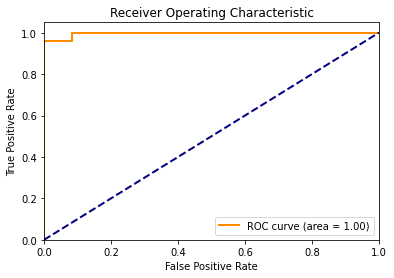

In [20]:
# Calculate the probabilities of the classes
y_prob = rfclf_tuned.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('../../data/roc_curve_drought_downsampled.pdf')
plt.show()

In [21]:
# Define a custom function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

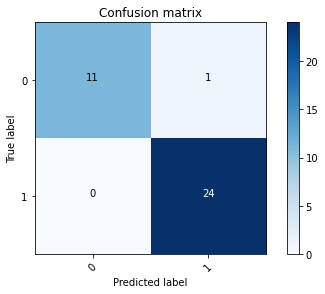

In [32]:
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1])
plt.show()

In [33]:
flood_log.head()

,BioProject,Treatment,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR1656746,PRJNA267717,Control,0,2.571453,3.100322,0.000000,2.324170,0.489994,1.152727,0.0,...,0.0,0.325871,0.425762,0.0,0.0,0.0,0.0,0.0,0.0,0.647908
SRR1656747,PRJNA267717,Control,0,1.546580,3.157299,0.095248,1.068310,0.000000,0.456112,0.0,...,0.0,0.330592,0.144683,0.0,0.0,0.0,0.0,0.0,0.0,1.154782
SRR1656748,PRJNA267717,Control,0,1.728674,3.026357,0.111172,1.075662,0.000000,0.669258,0.0,...,0.0,0.000000,0.028466,0.0,0.0,0.0,0.0,0.0,0.0,0.923362
SRR1656758,PRJNA267717,Flooding,1,0.591905,2.616303,0.000000,0.680880,0.000000,0.117627,0.0,...,0.0,0.000000,0.215789,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
SRR1656759,PRJNA267717,Flooding,1,1.287845,2.913773,0.158284,1.515598,0.088839,0.580917,0.0,...,0.0,0.347162,0.248853,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [23]:
# pull out gene expression values
X = flood_log.drop(["BioProject","Treatment","Label"],axis=1)

In [24]:
# code from Bob
# Get feature importances
feature_importances = rfclf_tuned.feature_importances_
# Create a list of (feature, importance) tuples
feature_importance_list = list(zip(X.columns, feature_importances))
# Sort the list by importance in descending order
sorted_feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
# Print the feature importances
print("Feature Importances:")
#for feature, importance in sorted_feature_importance_list:
#print(f"{feature}: {importance}")

Feature Importances:


In [28]:
pd.DataFrame(sorted_feature_importance_list,columns=["GeneID","Feature_Importance"]).to_csv("test.tsv",sep="\t",header=True,index=False)

In [29]:
# test saving confusion matrix
type(cm)

numpy.ndarray

In [33]:
pd.DataFrame(cm).to_csv("test.tsv",sep="\t",header=True,index=True)

In [42]:
# save y_prob to a file
with open("test.tsv","w+") as outfile:
    for i in list(y_prob):
        outfile.write(str(i)+"\n")

In [43]:
# extract hyperparameters as dictionary from model
rfclf_tuned.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [44]:
# save to a json
import json

In [48]:
with open("test.json","w+") as outfile:
    json.dump(rfclf_tuned.get_params(),outfile,indent=4)

In [84]:
import os

In [85]:
os.mkdir("./test")

In [86]:
flood_log.head()

,BioProject,Treatment,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442800,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR1656746,PRJNA267717,Control,0,2.571453,3.100322,0.000000,2.324170,0.489994,1.152727,0.0,...,0.0,0.325871,0.425762,0.0,0.0,0.0,0.0,0.0,0.0,0.647908
SRR1656747,PRJNA267717,Control,0,1.546580,3.157299,0.095248,1.068310,0.000000,0.456112,0.0,...,0.0,0.330592,0.144683,0.0,0.0,0.0,0.0,0.0,0.0,1.154782
SRR1656748,PRJNA267717,Control,0,1.728674,3.026357,0.111172,1.075662,0.000000,0.669258,0.0,...,0.0,0.000000,0.028466,0.0,0.0,0.0,0.0,0.0,0.0,0.923362
SRR1656758,PRJNA267717,Flooding,1,0.591905,2.616303,0.000000,0.680880,0.000000,0.117627,0.0,...,0.0,0.000000,0.215789,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
SRR1656759,PRJNA267717,Flooding,1,1.287845,2.913773,0.158284,1.515598,0.088839,0.580917,0.0,...,0.0,0.347162,0.248853,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
